# Classification

In [4]:
import pandas as pd, matplotlib.pyplot as plt, numpy as np
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.base import BaseEstimator

**1. Weekly Dataset**

This dataset tracks the weekly percentage returns for the S&P500 stock index between the years of 1990 and 2010.

The dataset consists of

* Year - the year the observation was recorded
* Lag1 - percentage return for the previous week
* Lag2 - percentage return for 2 weeks previous
* Lag3 - percentage return for 3 weeks previous
* Lag4 - percentage return for 4 weeks previous
* Lag5 - percentage return for 5 weeks previous
* Volume - the volume of shares traded (average number of daily shares traded in billions)
* Today - the percentage return for this week
* Direction - a factor with levels 'Down' and 'Up' indicating whether the market had a positive or negative return on a given week

In [5]:
weekly = pd.read_csv(r'C:\Users\caine\OneDrive\Documents\statistical_learning_problems\0 datasets\Weekly.csv')
weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


In [6]:
weekly.shape

(1089, 9)

In [7]:
weekly.isnull().sum(axis=0)

Year         0
Lag1         0
Lag2         0
Lag3         0
Lag4         0
Lag5         0
Volume       0
Today        0
Direction    0
dtype: int64

In [8]:
weekly['Direction'] = weekly['Direction'] == 'Up'

*(a) Produce some numerical and graphical summaries of the Weekly data. Do there appear to be any patterns?*

What are the important patterns that we want to begin to get an understanding of? Bearing in mind that this will be classification task.

Firstly we will want ot know if there are any significant between the response and precitors. There is little correlation between the lag variables and the direction. This is expected, if there was a consistent and strong correlation with the direction the market moved and the previous days returns then we would all be rich.

Next we might want to understand how the predictors are distributed? If they are approximately normal then we would expect discriminant analysis classifiers to perform well. Furthermore, we should calculate and report upon the mean and variance of the predictors for each class, if the variance is similar between classes then LDA should perform better than QDA and vice versa for the different variances. Next we want to know if there is any correlation between our predictors - no correlation between the predictor implies they are independent which is an assumption of the naive bayes classifier.

The first plot shows that the five lag variables are approximately normal, furthermore the table of descriptive statistics shows that all the lag variables have similar variances and means. The volume variable is not normally distributed. Finally, none of the responses appear to be correlated with each other.

An analysis of the variance for the two classes (Up and Down) reveals that the variance is very similar between the two classes. This means we expect a LDA to perform better than a QDA on this data. 

The descriptive statistics for each class also reveal that the lag variables tend to be higher when the market subsequently moves down versus when it moves up. The only exception here is the two week lag which is much lower when the market moves down and very high when the market moves up. We can show this more explicitly using boxplots.




In [9]:
weekly.corr()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
Year,1.000000,-0.032289,-0.033390,-0.030006,-0.031128,-0.030519,0.841942,-0.032460,-0.022200
Lag1,-0.032289,1.000000,-0.074853,0.058636,-0.071274,-0.008183,-0.064951,-0.075032,-0.050004
Lag2,-0.033390,-0.074853,1.000000,-0.075721,0.058382,-0.072499,-0.085513,0.059167,0.072696
Lag3,-0.030006,0.058636,-0.075721,1.000000,-0.075396,0.060657,-0.069288,-0.071244,-0.022913
Lag4,-0.031128,-0.071274,0.058382,-0.075396,1.000000,-0.075675,-0.061075,-0.007826,-0.020549
Lag5,-0.030519,-0.008183,-0.072499,0.060657,-0.075675,1.000000,-0.058517,0.011013,-0.018168
Volume,0.841942,-0.064951,-0.085513,-0.069288,-0.061075,-0.058517,1.000000,-0.033078,-0.017995
Today,-0.032460,-0.075032,0.059167,-0.071244,-0.007826,0.011013,-0.033078,1.000000,0.720025
Direction,-0.022200,-0.050004,0.072696,-0.022913,-0.020549,-0.018168,-0.017995,0.720025,1.000000


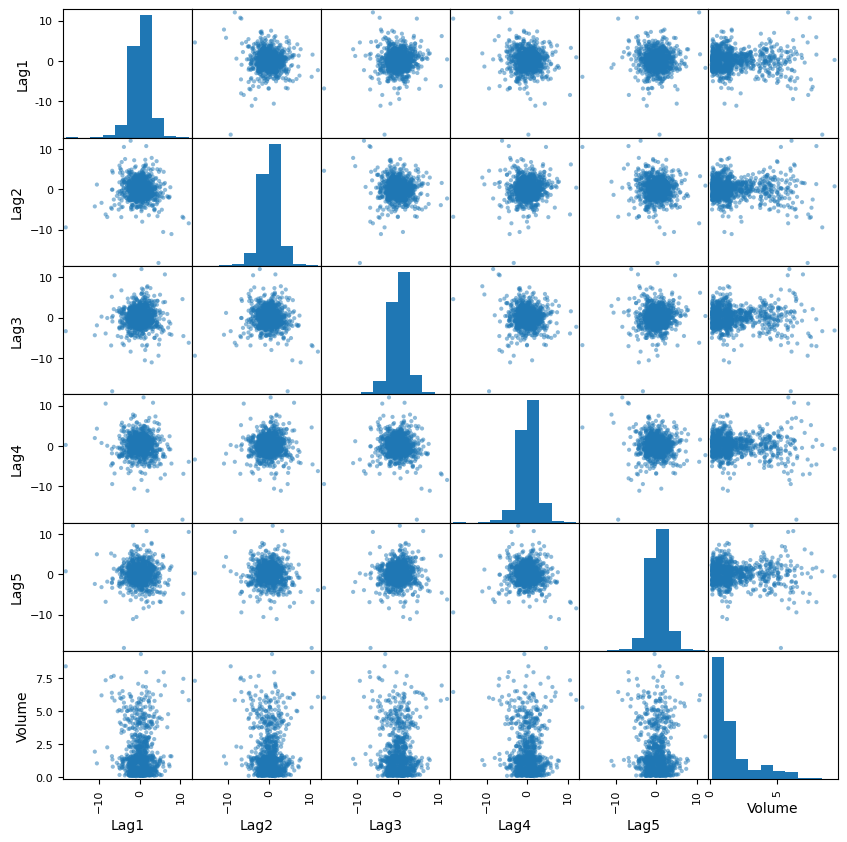

In [10]:
pd.plotting.scatter_matrix(weekly[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']], figsize=(10,10));

In [11]:
weekly[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']].describe()

,Lag1,Lag2,Lag3,Lag4,Lag5,Volume
count,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000
mean,0.150585,0.151079,0.147205,0.145818,0.139893,1.574618
std,2.357013,2.357254,2.360502,2.360279,2.361285,1.686636
min,-18.195000,-18.195000,-18.195000,-18.195000,-18.195000,0.087465
25%,-1.154000,-1.154000,-1.158000,-1.158000,-1.166000,0.332022
50%,0.241000,0.241000,0.241000,0.238000,0.234000,1.002680
75%,1.405000,1.409000,1.409000,1.409000,1.405000,2.053727
max,12.026000,12.026000,12.026000,12.026000,12.026000,9.328214


In [12]:
weekly[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']].corr()

,Lag1,Lag2,Lag3,Lag4,Lag5,Volume
Lag1,1.000000,-0.074853,0.058636,-0.071274,-0.008183,-0.064951
Lag2,-0.074853,1.000000,-0.075721,0.058382,-0.072499,-0.085513
Lag3,0.058636,-0.075721,1.000000,-0.075396,0.060657,-0.069288
Lag4,-0.071274,0.058382,-0.075396,1.000000,-0.075675,-0.061075
Lag5,-0.008183,-0.072499,0.060657,-0.075675,1.000000,-0.058517
Volume,-0.064951,-0.085513,-0.069288,-0.061075,-0.058517,1.000000


In [13]:
up_weekly = weekly[weekly['Direction'] == True]
down_weekly = weekly[weekly['Direction'] == False]

In [14]:
up_weekly[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']].describe()

,Lag1,Lag2,Lag3,Lag4,Lag5,Volume
count,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000
mean,0.045217,0.304281,0.098851,0.102456,0.101539,1.547483
std,2.387016,2.399210,2.422562,2.292767,2.354294,1.677560
min,-18.195000,-11.050000,-18.195000,-9.399000,-11.050000,0.125075
25%,-1.237000,-1.001000,-1.173000,-1.158000,-1.201000,0.327292
50%,0.099000,0.299000,0.224000,0.241000,0.128000,0.926580
75%,1.313000,1.463000,1.417000,1.352000,1.338000,2.089900
max,10.707000,12.026000,12.026000,10.707000,12.026000,8.403358


In [15]:
down_weekly[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']].describe()

,Lag1,Lag2,Lag3,Lag4,Lag5,Volume
count,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000
mean,0.282295,-0.040424,0.207647,0.200021,0.187835,1.608536
std,2.314676,2.291823,2.281604,2.443355,2.371558,1.699041
min,-9.399000,-18.195000,-10.538000,-18.195000,-18.195000,0.087465
25%,-0.936500,-1.307250,-1.155000,-1.154250,-1.093750,0.337758
50%,0.382000,0.154000,0.250500,0.223500,0.328000,1.073550
75%,1.588750,1.302250,1.406000,1.441500,1.502000,2.019929
max,12.026000,10.491000,10.491000,12.026000,10.491000,9.328214


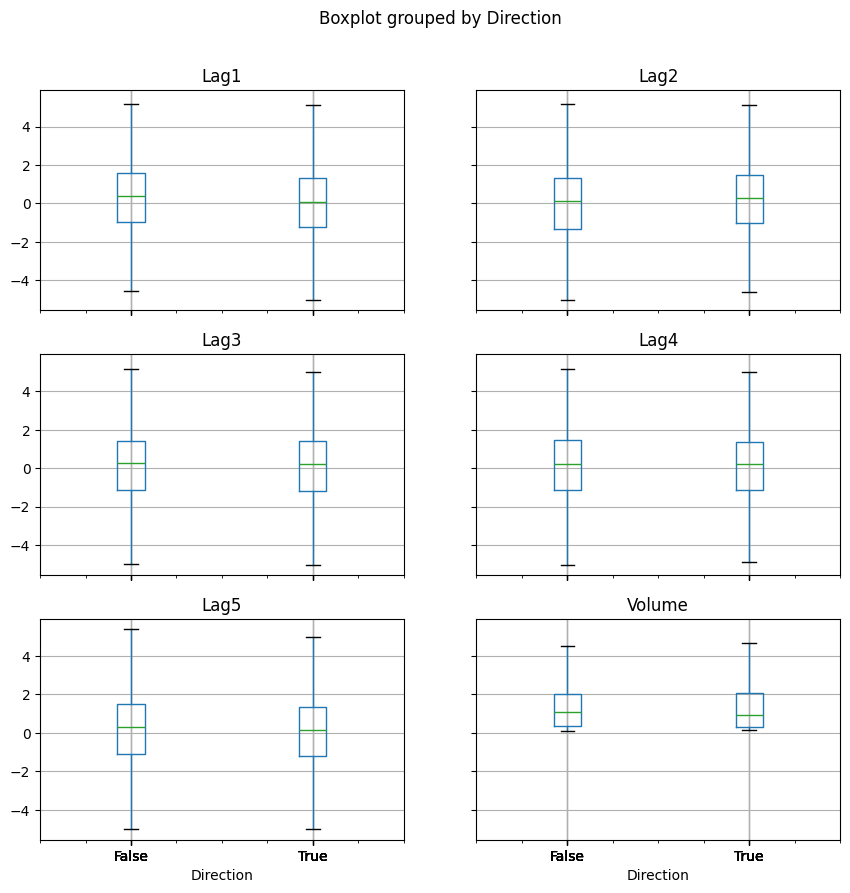

In [16]:
weekly.boxplot(['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume'], 'Direction', figsize=(10,10), showfliers=False);

*(b) Use the full data set to perform a logistic regression with `Direction` as the response and the `five lag` variables plus Volume as predictors. Use the summary function to print the results. Do any of the predictors appear to be statistically significant? If so, which ones?*

Looking at the p-values of the model outputs we notice that only the lag 2 variable is statistically significant at 0.05 level. It has a coefficient equal to 0.0594. This means that every 1 unit increase in the the return from 2-weeks prior is associated with an increases in the log odds of 0.0594. Put simply, the higher the market return 2 weeks prior the greater the probability that the market moves upwards today.

In [17]:
X = weekly.drop(['Direction', 'Today'], axis=1)
X['constant'] = 1
y = weekly['Direction']

logisitic = sm.GLM(y.to_numpy(), X, sm.families.Binomial());
results = logisitic.fit();
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 1089
Model:                            GLM   Df Residuals:                     1081
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -743.08
Date:                Tue, 11 Jun 2024   Deviance:                       1486.2
Time:                        18:59:45   Pearson chi2:                 1.09e+03
No. Iterations:                     4   Pseudo R-squ. (CS):           0.009182
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Year          -0.0085      0.019     -0.448      0.654      -0.046       0.029
Lag1          -0.0407      0.026     -1.538      0.124      -0.093       0.011
Lag2           0.0594      0.027      2.204      0.028       0.007       0.112
Lag3          -0.0155      0.027     -0.580      0.562      -0.068       0.037
Lag4          -0.0273      0.026     -1.031      0.302      -0.079       0.025
Lag5          -0.0140      0.026     -0.531      0.595      -0.066       0.038
Volume         0.0033      0.069      0.047      0.962      -0.132       0.138
constant      17.2258     37.891      0.455      0.649     -57.038      91.490
==============================================================================
"""

*(c) Compute the confusion matrix and overall fraction of correct predictions. Explain what the confusion matrix is telling you about the types of mistakes made by logistic regression.*

We can compute the overall accuracy score by using the builtin `accuracy_score` function provided by sci-kit. This return the ratio of correctly labelled observations to total observations. Below we see that the logistic regression correctly classified the direction of the market would move for 56% of the observations in the training data.

A confusion matrix compares the classification predictions made by a model with the the true classifications. However, where as the accuracy score simply looks at the ratio of correctly labelled observation to total observation, a confusion matrix allows us to analyse the ratio of correctly labelled positive and negative predictions. This goes one step further than simple accuracy score in that it allows us to understand the types of errors our model is making. 

To compute the confusion matrix we can use the builtin `confusion_matrix` function provided by sci-kit. The outputs are below. The layout of the confusion matrix is as follows: the first row captures the observations predicted to be negative, that is, the model predicted the market would move downwards, the second row captures the predicted poistives, the first column are the actual negatives and the second column are the actual positives. We see that this model correctly classified $56/103$ of the actual negatives and $558/986$ of the actual positives. Most of the errors made were classifying an upward movement of the market as a downward movement (a false negative), this type of error accounted for $428/475$ of all the errors the model made.



In [18]:
accuracy_score(y.to_numpy(), results.predict() > 0.5)

0.5638200183654729

In [19]:
confusion_matrix(y_true=y.to_numpy(), y_pred=results.predict() > 0.5)

array([[ 56, 428],
       [ 47, 558]], dtype=int64)

*(d) Now fit the logistic regression model using a training data period from 1990 to 2008, with `Lag2` as the only predictor. Compute the confusion matrix and the overall fraction of correct predictions for the held out data*

Firstly, we need to split our data into a training a test set. We do this by filtering the pandas dataframe for observations where the value of year is less than or equal to 2008 (training set) and then for observations where the year is the strictly greater than 2008 (test set).

We then fit the model to the training data and evaluate its performance on the test data. Because the following questions ask us to repeat this process for different classification models we should write a function that can take a model as a parameter, fit the model and then evaluate it. 

In [20]:
weekly_training = weekly[weekly['Year'] <= 2008]
weekly_test = weekly[weekly['Year'] > 2008]

In [21]:
def fit_and_evaluate_model(model, training=weekly_training, test=weekly_test):
     X_train = training['Lag2'].to_numpy().reshape(-1, 1)
     X_test = test['Lag2'].to_numpy().reshape(-1, 1)
     y_train = training['Direction'].to_numpy()
     y_test = test['Direction'].to_numpy()
     
     model.fit(X_train, y_train)
     y_pred = model.predict(X_test)

     print(f'accuracy score = {accuracy_score(y_test, y_pred)}\n')
     print('Confusion matrix\n')
     print(confusion_matrix(y_test, y_pred))


In [22]:
fit_and_evaluate_model(LogisticRegression(penalty=None))

accuracy score = 0.625

Confusion matrix

[[ 9 34]
 [ 5 56]]


*(e) Repeat (d) using LDA.*

In [23]:
fit_and_evaluate_model(LDA())

accuracy score = 0.625

Confusion matrix

[[ 9 34]
 [ 5 56]]


*(f) Repeat (d) using QDA.*

In [24]:
fit_and_evaluate_model(QDA())

accuracy score = 0.5865384615384616

Confusion matrix

[[ 0 43]
 [ 0 61]]


*(g) Repeat (d) using KNN with K = 1.*

In [25]:
fit_and_evaluate_model(KNeighborsClassifier(1))

accuracy score = 0.5096153846153846

Confusion matrix

[[22 21]
 [30 31]]


*(h) Repeat (d) using naive Bayes.*

In [26]:
fit_and_evaluate_model(GaussianNB())

accuracy score = 0.5865384615384616

Confusion matrix

[[ 0 43]
 [ 0 61]]


*(i) Which of these methods appears to provide the best results on this data?*

The results show that the best methods for predicting the direction of the stock market bases on the returns two-weeks-prior are logistic regression and linear discriminant analysis.

*(j) Experiment with different combinations of predictors, including possible transformations and interactions, for each of the methods. Report the variables, method, and associated confusion matrix that appears to provide the best results on the held out data. Note that you should also experiment with values for K in the KNN classifier.*

If we limit ourselves to the lag variables only there are five predictors. There are $2^{p}$ or $32$ possible models to test which means it is feasible to test all combinations of the predictors. Lets test the combinations first and then move onto to experimenting with transformations and interactions. 

First we will write a function to return a list of lists containing all the possible combinations of the lag predictors. The function `get_predictor_combinations` provides this functionality. It iterates through the length of the predictors list passed to it and at each iteration produces all of the combinations of the predictors of length `r`.

Then lets write a function, `fit_and_evaluate_models_and_predictor_combinations`, that can take multiple models and the combinations of the predictors. This function should fit each model with each combination of the predictors and should store the accuracy score, type 1 error rate (proportion of negatives classified as positives), recall (true positive rate) and, precision (proportion of predicted positives that are true positives). This will allow for an evaluation of the combination of predictors. To keep the code modular we will write a function, `evaluate_confusion_matrix` that can take a confusion matrix as an argument and return the desired evaluation metrics.

In [27]:
from itertools import combinations

def get_predictor_combinations(predictors:list[str]) -> list[list[str]]:
    predictor_combinations = []
    for r in range(1, len(predictors)+1):
        predictor_combinations.extend(list(map(list, combinations(predictors, r))))
    
    return predictor_combinations


In [28]:
predictor_combinations = get_predictor_combinations(list(filter(lambda col: col.startswith('Lag'), weekly.columns)))

In [29]:
def evaluate_confusion_matrix(c_matrix: np.ndarray) -> tuple[float]:
    t1_error = c_matrix[1, 0] / c_matrix[:, 0].sum()
    recall = c_matrix[1, 1] / c_matrix[:, 1].sum()
    precision = c_matrix[1, 1] / c_matrix[1, :].sum()

    return t1_error, recall, precision


In [30]:
def fit_and_evaluate_models_and_predictor_combinations(models: list, predictor_combinations:list[list[str]], training=weekly_training, test=weekly_test) -> pd.DataFrame:

    evaluation_df = pd.DataFrame(
        columns = ['Model', 'Predictors', 'Accuracy', 'Type 1 Error', 'Recall', 'Precision']
    )

    y_train = training['Direction'].to_numpy()
    y_test = test['Direction'].to_numpy()

    for model in models:
        model_name = model.__repr__()
        for predictors in predictor_combinations:
            predictors_name = ",".join(predictors)
            eval_row = [model_name, predictors_name]

            X_train = training[predictors].to_numpy()
            X_test = test[predictors].to_numpy()
            
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            c_matrix = confusion_matrix(y_test, y_pred)

            eval_row.append(accuracy_score(y_test, y_pred))
            eval_row.extend(evaluate_confusion_matrix(c_matrix))

            evaluation_df.loc[len(evaluation_df), :] = eval_row

    return evaluation_df

    

In [31]:
models = [LogisticRegression(penalty=None), LDA(), QDA(), KNeighborsClassifier(3), KNeighborsClassifier(6), KNeighborsClassifier(9), GaussianNB()]

In [32]:
evaluation_df = fit_and_evaluate_models_and_predictor_combinations(models, predictor_combinations);
evaluation_df.sort_values('Accuracy', ascending=False).iloc[0:20]

C:\Users\caine\AppData\Local\Temp\ipykernel_20032\3691585736.py:2: RuntimeWarning: invalid value encountered in scalar divide
  t1_error = c_matrix[1, 0] / c_matrix[:, 0].sum()
C:\Users\caine\AppData\Local\Temp\ipykernel_20032\3691585736.py:2: RuntimeWarning: invalid value encountered in scalar divide
  t1_error = c_matrix[1, 0] / c_matrix[:, 0].sum()
C:\Users\caine\AppData\Local\Temp\ipykernel_20032\3691585736.py:2: RuntimeWarning: invalid value encountered in scalar divide
  t1_error = c_matrix[1, 0] / c_matrix[:, 0].sum()
C:\Users\caine\AppData\Local\Temp\ipykernel_20032\3691585736.py:2: RuntimeWarning: invalid value encountered in scalar divide
  t1_error = c_matrix[1, 0] / c_matrix[:, 0].sum()
C:\Users\caine\AppData\Local\Temp\ipykernel_20032\3691585736.py:2: RuntimeWarning: invalid value encountered in scalar divide
  t1_error = c_matrix[1, 0] / c_matrix[:, 0].sum()
C:\Users\caine\AppData\Local\Temp\ipykernel_20032\3691585736.py:2: RuntimeWarning: invalid value encountered in sca

,Model,Predictors,Accuracy,Type 1 Error,Recall,Precision
32,LinearDiscriminantAnalysis(),Lag2,0.625,0.357143,0.622222,0.918033
29,LogisticRegression(penalty=None),"Lag2,Lag3,Lag4,Lag5",0.625,0.357143,0.622222,0.918033
40,LinearDiscriminantAnalysis(),"Lag2,Lag3",0.625,0.333333,0.619565,0.934426
41,LinearDiscriminantAnalysis(),"Lag2,Lag4",0.625,0.333333,0.619565,0.934426
60,LinearDiscriminantAnalysis(),"Lag2,Lag3,Lag4,Lag5",0.625,0.357143,0.622222,0.918033
9,LogisticRegression(penalty=None),"Lag2,Lag3",0.625,0.333333,0.619565,0.934426
10,LogisticRegression(penalty=None),"Lag2,Lag4",0.625,0.333333,0.619565,0.934426
1,LogisticRegression(penalty=None),Lag2,0.625,0.357143,0.622222,0.918033
117,KNeighborsClassifier(n_neighbors=3),"Lag3,Lag4,Lag5",0.625,0.45,0.671875,0.704918
53,LinearDiscriminantAnalysis(),"Lag2,Lag3,Lag5",0.615385,0.363636,0.612903,0.934426


Nine models achieve an accuracy of 62.5%, recall that this is no better than the logistic regression or LDA model with only `Lag2` as a predictor. Nonetheless, we do notice some important distinctions. 

Firstly, the LDA model with Lag2 and Lag3 as predictors achieves a higher precision than the model with just Lag2, this comes at the cost of higher recall. That is, when we include Lag3 we correctly predict fewer of the true increases in the stock market, however, those that we do predict are more likely to be correct.

Second, note the performance of the KNN classifier with the number of neighbours set to 3. It also achieves an accuracy of 62.5%. Compare this to the KNN model with 1 neighbour that used only Lag2 variable above - it only achieved an accuracy 50%. This might indicate some highly nonlinear relationship between the direction of the market and the Lag3, Lag4 and Lag5 predictors.

Thridly, we see a noticeable improvement in the QDA model when we include the Lag3 predictor alongside Lag2. In the Lag2 model QDA achieved an accuracy of 58%, when we include Lag3 this increases to 60.5%. We get further improvements using QDA when we model the direction of the market based on the Lag1 and Lag3 variables. 

**2. Predicting high/low Mpg - the Auto dataset**

**3. Some functions and transformations**

*(a) Write a function, `Power()`, that prints out the result of raising 2 to the 3rd power. In other words, your function should compute $2^{3}$ and print out the results.*

In [33]:
def power():
    """
    This pretty useless function always returns 
    :math: `2^{3}`
    """
    return 2**3

*(b) Create a new function, `Power2()`, that allows you to pass any two numbers, x and a, and prints out the value of $x^{a}$.*

In [34]:
def power2(x, a):
    """
    This slghtly more useful function will return
    :math:`x^{a}`
    """
    return x**a

*(c) Using the `Power2()` function that you just wrote, compute $10^{3}$, $8^{17}$, and $131^{3}$.*

In [35]:
print(power2(10, 3))
print(power2(8, 17))
print(power2(131, 3))

1000
2251799813685248
2248091


*(d) Now using the `Power2()` function, create a plot of $f(x) = x^{2}$. The x-axis should display a range of integers from 1 to 10, and the y-axis should display $x^{2}$. Label the axes appropriately, and use an appropriate title for the figure. Consider displaying either the x-axis, the y-axis, or both on the log-scale.*

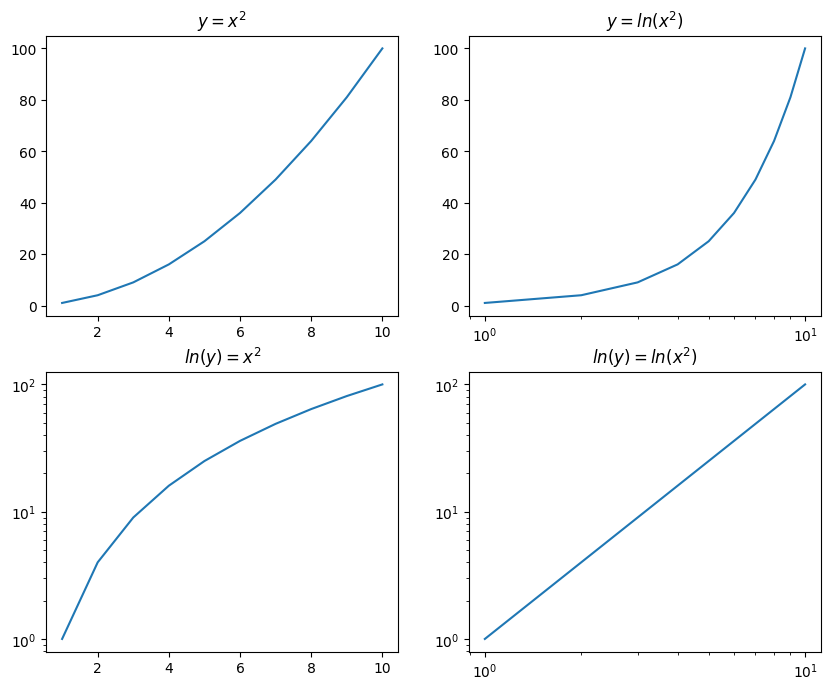

In [36]:
x = [i for i in range(1, 11)]
y = [power2(i, 2) for i in x]

figure, ax = plt.subplots(2,2, figsize=(10,8))
ax[0][0].plot(x, y)
ax[0][0].set_title('$y = x^{2}$')

ax[0][1].plot(x, y)
ax[0][1].set_xscale('log')
ax[0][1].set_title('$y = ln(x^{2})$')

ax[1][0].plot(x, y)
ax[1][0].set_yscale('log')
ax[1][0].set_title('$ln(y) = x^{2}$')

ax[1][1].plot(x, y)
ax[1][1].set_yscale('log')
ax[1][1].set_xscale('log')
ax[1][1].set_title('$ln(y) = ln(x^{2})$');




*(e) Create a function, `PlotPower()`, that allows you to create a plot of x against x**a for a fixed a and a sequence of values of x.*

In [37]:
def plot_power(x_range, pow):
    """
    Creates a plot of :math: `y = x^{pow}`

    **usage**
    For each value in x-range calculates the value of :math:x^{pow}
    Then plots this sequence
    """
    y = [power2(i, pow) for i in x_range]

    figure = plt.figure(figsize=(8,6))
    ax = figure.add_subplot()

    ax.plot(x_range, y)
    

    

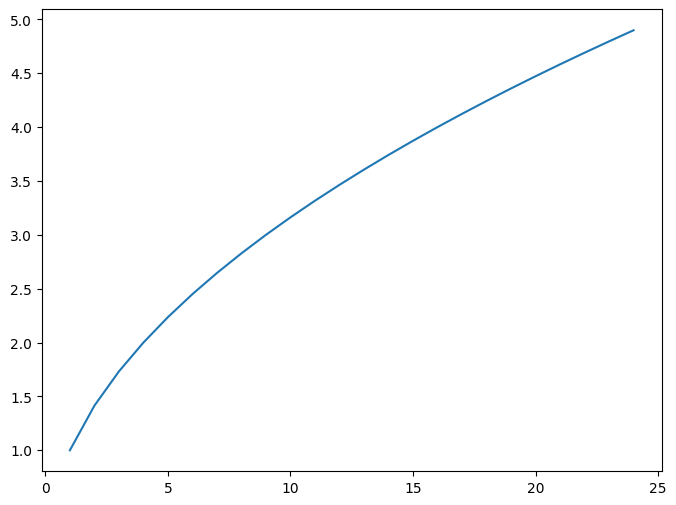

In [38]:
plot_power(np.arange(1, 25), 1/2)

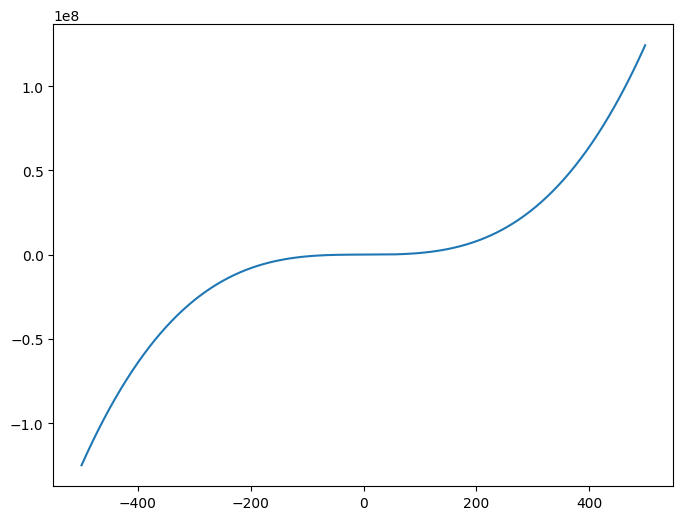

In [39]:
plot_power(np.arange(-500, 500), 3)

*(4) Using the `Boston` data set, fit classification models in order to predict whether a given suburb has a crime rate above or below the median. Explore logistic regression, LDA, naive Bayes, and KNN models using various subsets of the predictors. Describe your findings.*

In [40]:
boston = pd.read_csv(r'C:\Users\caine\OneDrive\Documents\statistical_learning_problems\0 datasets\Boston.csv')

In [41]:
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


In [44]:
boston.shape

(506, 14)

In [42]:
boston.isna().sum()

CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64

In [45]:
boston = boston.dropna()

In [46]:
boston.shape

(394, 14)

First lets create the response variables `CRIM01` where a 1 indicates a crime rate above the median and a 0 a crime rate below the median.

In [47]:
boston['CRIM01'] = boston['CRIM'] > boston['CRIM'].median()

In [54]:
boston['CRIM01'] = boston['CRIM01'].astype(float)

In [49]:
boston.drop('CRIM', axis=1, inplace=True)

Now we will start to explore the data to find the predictors that are correlated with the response. We will also look at the relationships between the predictors themselves.

In [50]:
boston.corr()

,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,CRIM01
ZN,1.000000,-0.521256,-0.033357,-0.515660,0.343210,-0.568174,0.645359,-0.298773,-0.305768,-0.422164,0.169894,-0.415041,0.406822,-0.423035
INDUS,-0.521256,1.000000,0.049820,0.762737,-0.403068,0.642387,-0.696569,0.591944,0.734204,0.395691,-0.344788,0.598156,-0.510829,0.578626
CHAS,-0.033357,0.049820,1.000000,0.076661,0.095308,0.072644,-0.095037,0.014102,-0.026513,-0.104995,0.068913,-0.037113,0.173701,0.070321
NOX,-0.515660,0.762737,0.076661,1.000000,-0.316563,0.732540,-0.768137,0.628170,0.679824,0.210216,-0.384257,0.593655,-0.459054,0.706432
RM,0.343210,-0.403068,0.095308,-0.316563,1.000000,-0.248670,0.218713,-0.236057,-0.320561,-0.390686,0.123320,-0.636226,0.723951,-0.182024
AGE,-0.568174,0.642387,0.072644,0.732540,-0.248670,1.000000,-0.753547,0.443585,0.504472,0.264968,-0.281990,0.601137,-0.407470,0.596718
DIS,0.645359,-0.696569,-0.095037,-0.768137,0.218713,-0.753547,1.000000,-0.477075,-0.529603,-0.228840,0.285168,-0.505036,0.279547,-0.586480
RAD,-0.298773,0.591944,0.014102,0.628170,-0.236057,0.443585,-0.477075,1.000000,0.900000,0.441949,-0.444135,0.510868,-0.416638,0.607254
TAX,-0.305768,0.734204,-0.026513,0.679824,-0.320561,0.504472,-0.529603,0.900000,1.000000,0.446961,-0.435457,0.572218,-0.508864,0.585648
PTRATIO,-0.422164,0.395691,-0.104995,0.210216,-0.390686,0.264968,-0.228840,0.441949,0.446961,1.000000,-0.179816,0.395006,-0.543809,0.246334


In [52]:
boston

,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,CRIM01
0,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0,False
1,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6,False
2,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7,False
3,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4,False
5,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,0.0,9.69,0.0,0.585,5.569,73.5,2.3999,6,391,19.2,395.77,15.10,17.5,False
500,0.0,9.69,0.0,0.585,6.027,79.7,2.4982,6,391,19.2,396.90,14.33,16.8,False
502,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6,False
503,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9,False


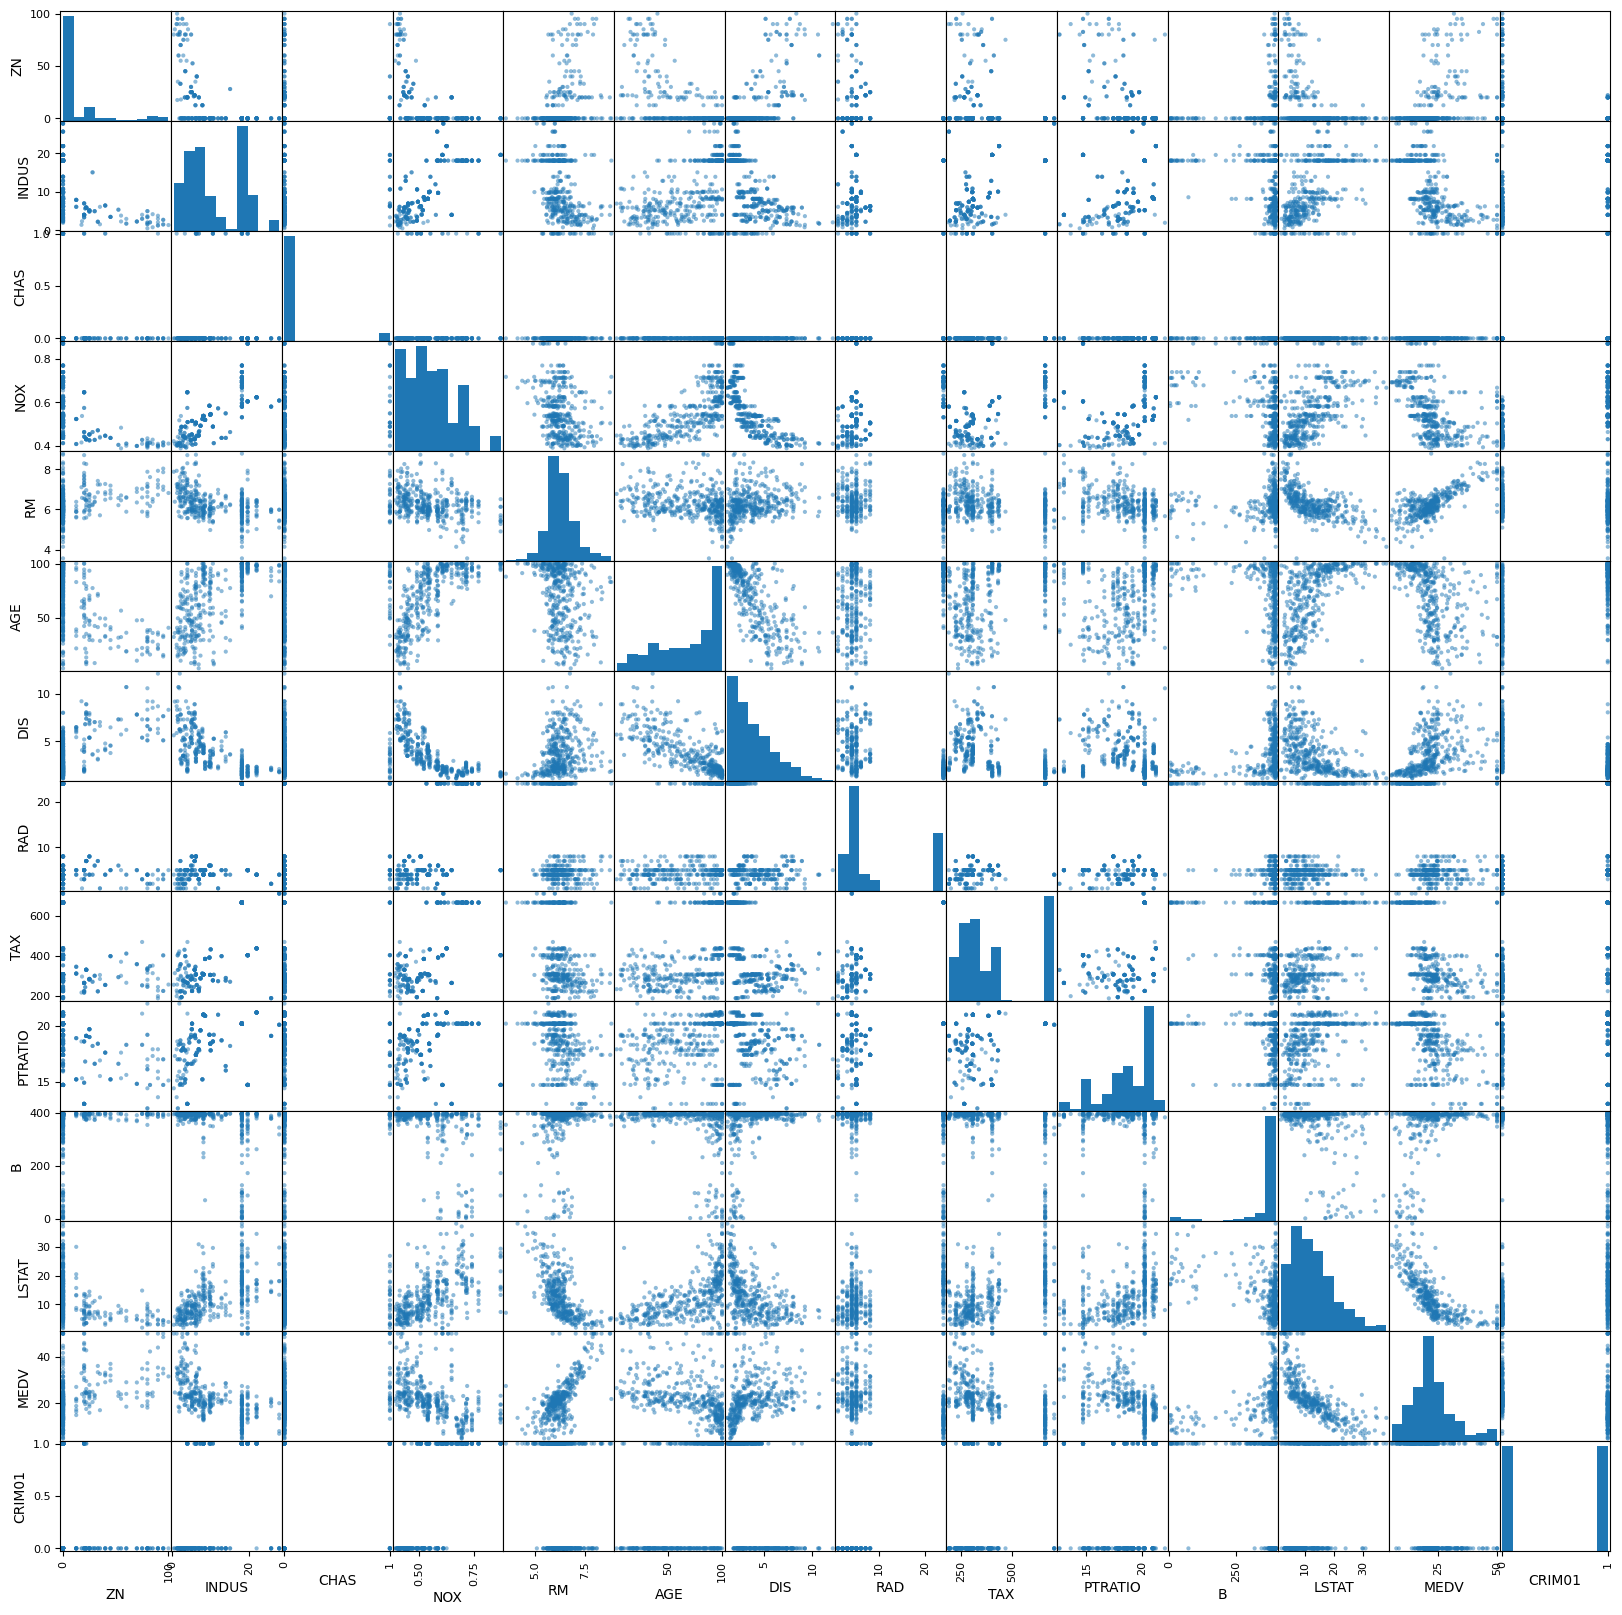

In [56]:
pd.plotting.scatter_matrix(boston, figsize=(20, 20));